# Intro

The tests were ran on `Debian 6.1.140-1 x86_64 GNU/Linux` using 
`Oracle GraalVM 21.0.7` for Java. The environment featured an Intel(R) Xeon(R) CPU @ 2.20GHz (8 cores) and 32GB RAM.

The configuration files used for benchmarking are located in the **/report/configs/** folder.

The JVM options used for the benchmarks are specified in the configuration files in **/report/configs/**. For example:
- For JVM with G1GC: `-Xmx2g -Xss1m -XX:+UseG1GC`
  - This means the Java process will use up to 2 gigabytes of memory for the heap, set each thread's stack size to 1 megabyte, and use the G1 garbage collector to manage memory.
- For JVM Shenandoah: `-Xmx2g -Xss1m -XX:+UseShenandoahGC`
  - This means the Java process will use up to 2 gigabytes of memory for the heap, set each thread's stack size to 1 megabyte, and use the Shenandoah garbage collector, which is designed for low pause times.
- For Native: `-H:MaxHeapSize=2g -H:StackSize=1m`
  - This means the maximum amount of memory the application can use for its heap is set to 2 gigabytes, and each thread will have a stack size of 1 megabyte. These options help control memory usage and prevent the application from using more resources than intended when running as a native executable.
 
These options control the maximum heap size, thread stack size, and the garbage collector used during the benchmarks.

All dependencies required to run the Jupyter notebook are listed in requirements.txt.

To ensure accurate results, we use WRK2 as the workload generator with the following key parameters:

```bash
# output copied from wrk2 help page
  Options:
     -c, --connections <N>  Connections to keep open
     -d, --duration    <T>  Duration of test
     -t, --threads     <N>  Number of threads to use
     ...
     -R, --rate        <T>  work rate (throughput)
                            in requests/sec (total)
                            [Required Parameter]
```
 
- **Connections**: Set to 100, which ensures enough concurrent connections without overwhelming the system.
- **Duration**: Set to 30 seconds to provide a stable testing window.
- **Threads**: Set to 2 to provide sufficient concurrency for the workload generator to utilize CPU resources efficiently without causing excessive context switching.
- **Rate**: Set to 2000 requests per second.

## About the Benchmarks
 
The **Quarkus Tika** benchmark focuses on file serialization and deserialization tasks, leveraging the Tika library to process and extract metadata from files. This allows us to measure not only HTTP request/response performance but also the efficiency of handling real-world file I/O and content extraction scenarios in both JVM and native modes.
 
The benchmarks also include applications built with **Quarkus** and **Micronaut** frameworks. These represent modern, cloud-native Java stacks designed for fast startup and low memory usage, making them ideal for serverless and containerized environments. By comparing Quarkus and Micronaut in both JVM and native image modes, we can assess their relative strengths in terms of startup time, throughput, and resource efficiency under realistic workloads.




# Startup and Response time

Startup time and response latency are critical metrics for evaluating serverless and microservice applications, especially in dynamic environments like cloud deployments or autoscaling systems. Fast startup ensures quicker availability of services (e.g., during cold starts), while low response time improves user experience and system efficiency.

When comparing **JVM** vs. **Native Image** execution, these metrics highlight key trade-offs:

- JVM offers runtime optimizations via JIT but often has slower startup due to classloading and warm-up overhead.
- Native images (e.g., compiled with GraalVM) eliminate JIT and preinitialize application state, potentially reducing both startup and tail latency.

**Hypotheses**:
- *Startup Time*: We expect native images to start significantly faster than JVM applications.
- *Response Time*: We hypothesize that native images will exhibit lower and more consistent latency, especially during cold starts.

In [1]:
#imports
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
from datetime import datetime
from pathlib import Path
import json

In [2]:
base_path_petclinic_jvm_g1gc = './data/petclinic-jvm-g1gc'
base_path_petclinic_jvm_shenandoah = './data/petclinic-jvm-shenandoah'
base_path_petclinic_native = './data/petclinic-native'

base_path_tika_jvm_g1gc = './data/tika-jvm-g1gc'
base_path_tika_jvm_shenandoah = './data/tika-jvm-shenandoah'
base_path_tika_native = './data/tika-native'

base_path_shopcart_jvm_g1gc = './data/shopcart-jvm-g1gc'
base_path_shopcart_jvm_shenandoah = './data/shopcart-jvm-shenandoah'
base_path_shopcart_native = './data/shopcart-native'

def process_all_files(base_dir, process_file_func, *func_args) -> pd.DataFrame:
    result_df = pd.DataFrame()
    for entry in os.listdir(base_dir):
        result_df = pd.concat([result_df, process_file_func(os.path.join(base_dir, entry), *func_args)], ignore_index=True)
    return result_df


Text(0.5, 1.0, 'Micronaut Shopcart')

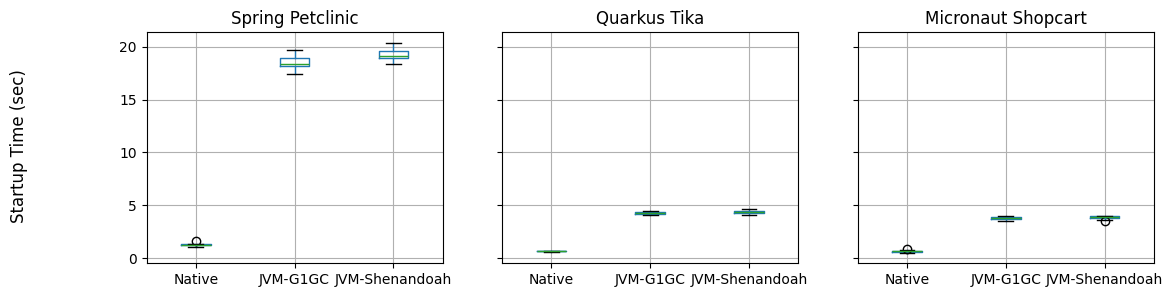

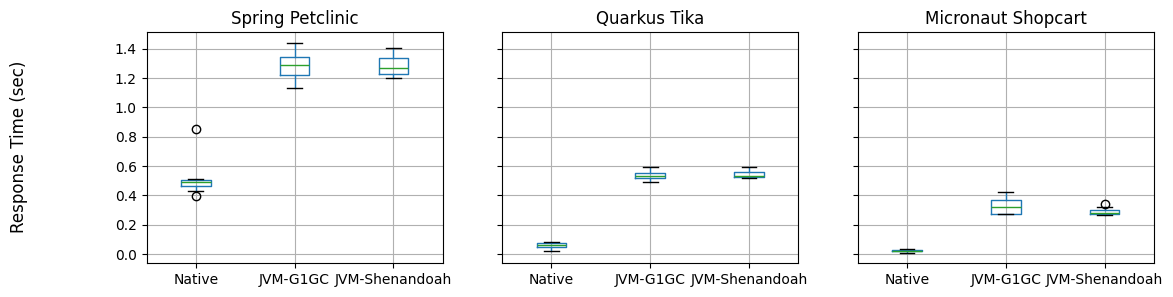

In [26]:
# returns pd.DataFrame["startup", "response_duration"]
def parse_first_time_response(full_path, prefix) -> pd.DataFrame:
    full_path = os.path.join(full_path, "first-response.csv")
    df = pd.read_csv(full_path)
    for col in ["request_timestamp", "response_timestamp", "benchmark_container_start_timestamp"]:
        df[col] = df[col].apply(lambda it: datetime.strptime(it, "%b %d %H:%M:%S.%f"))
    df[f"{prefix}_startup"] = (df["response_timestamp"] - df["benchmark_container_start_timestamp"]).dt.total_seconds()
    df[f"{prefix}_response"] = (df["response_timestamp"] - df["request_timestamp"]).dt.total_seconds()
    return df[[f"{prefix}_startup", f"{prefix}_response"]]


first_time_response_spring_df = pd.concat([
    process_all_files(base_path_petclinic_jvm_g1gc, parse_first_time_response, "jvm-g1gc"),
    process_all_files(base_path_petclinic_jvm_shenandoah, parse_first_time_response, "jvm-shenandoah"),
    process_all_files(base_path_petclinic_native, parse_first_time_response, "native")
], axis=1)

first_time_response_quarkus_hello_df = pd.concat([
    process_all_files(base_path_tika_jvm_g1gc, parse_first_time_response, "jvm-g1gc"),
    process_all_files(base_path_tika_jvm_shenandoah, parse_first_time_response, "jvm-shenandoah"),
    process_all_files(base_path_tika_native, parse_first_time_response, "native")
], axis=1)

first_time_response_micronaut_df = pd.concat([
    process_all_files(base_path_shopcart_jvm_g1gc, parse_first_time_response, "jvm-g1gc"),
    process_all_files(base_path_shopcart_jvm_shenandoah, parse_first_time_response, "jvm-shenandoah"),
    process_all_files(base_path_shopcart_native, parse_first_time_response, "native")
], axis=1)

fig, axes = plt.subplots(1, 3, figsize=(13, 3), sharey=True)
fig.supylabel("Startup Time (sec)")
first_time_response_spring_df[["native_startup", "jvm-g1gc_startup", "jvm-shenandoah_startup"]] \
.rename(columns={
        "native_startup": "Native",
        "jvm-g1gc_startup": "JVM-G1GC",
        "jvm-shenandoah_startup": "JVM-Shenandoah"
}).boxplot(ax=axes[0])
axes[0].set_title('Spring Petclinic')

first_time_response_quarkus_hello_df[["native_startup", "jvm-g1gc_startup", "jvm-shenandoah_startup"]]\
.rename(columns={
        "native_startup": "Native",
        "jvm-g1gc_startup": "JVM-G1GC",
        "jvm-shenandoah_startup": "JVM-Shenandoah"
}).boxplot(ax=axes[1])
axes[1].set_title('Quarkus Tika')

first_time_response_micronaut_df[["native_startup", "jvm-g1gc_startup", "jvm-shenandoah_startup"]]\
    .rename(columns={
        "native_startup": "Native",
        "jvm-g1gc_startup": "JVM-G1GC",
        "jvm-shenandoah_startup": "JVM-Shenandoah"
}).boxplot(ax=axes[2])
axes[2].set_title('Micronaut Shopcart')

fig, axes = plt.subplots(1, 3, figsize=(13, 3), sharey=True)
fig.supylabel("Response Time (sec)")
first_time_response_spring_df[["native_response", "jvm-g1gc_response", "jvm-shenandoah_response"]]\
    .rename(columns={
        "native_response": "Native",
        "jvm-g1gc_response": "JVM-G1GC",
        "jvm-shenandoah_response": "JVM-Shenandoah"
}).boxplot(ax=axes[0])
axes[0].set_title('Spring Petclinic')

first_time_response_quarkus_hello_df[["native_response", "jvm-g1gc_response", "jvm-shenandoah_response"]]\
    .rename(columns={
        "native_response": "Native",
        "jvm-g1gc_response": "JVM-G1GC",
        "jvm-shenandoah_response": "JVM-Shenandoah"
}).boxplot(ax=axes[1])
axes[1].set_title('Quarkus Tika')

first_time_response_micronaut_df[["native_response", "jvm-g1gc_response", "jvm-shenandoah_response"]]\
    .rename(columns={
        "native_response": "Native",
        "jvm-g1gc_response": "JVM-G1GC",
        "jvm-shenandoah_response": "JVM-Shenandoah"
}).boxplot(ax=axes[2])
axes[2].set_title('Micronaut Shopcart')



The results show that native images clearly outperform JVM execution across all applications (Spring Petclinic, Quarkus Tika, Micronaut Shopcart). Native executables deliver 5×–20× faster startup and 2×–5× lower response times, with far less variance, making performance more predictable. JVM runs are slower and more variable due to JIT warm-up and garbage collection.

Native runs are also more predictable, while JVM runs vary more due to GC behavior (G1GC vs. Shenandoah) and JIT warm-up.

# Latency and Throughput

**Latency** reflects how quickly an application handles individual requests, which directly impacts user experience and system responsiveness. **Throughput** (measured in requests per second) indicates how well the system handles load and scales under pressure. Together, these metrics give a holistic view of runtime efficiency.

In microservice and serverless environments—where services must handle bursts of traffic or maintain low tail latencies—these performance factors are critical.

Hypotheses
- *Latency*: We expect GraalVM native images to offer lower and more stable request latency due to ahead-of-time optimization and reduced GC activity.
- *Throughput*: We expect native images to match or slightly improve throughput compared to JVM, although in some cases the JVM’s JIT may deliver marginal gains under sustained load.

Text(0.5, 1.0, 'Micronaut Shopcart')

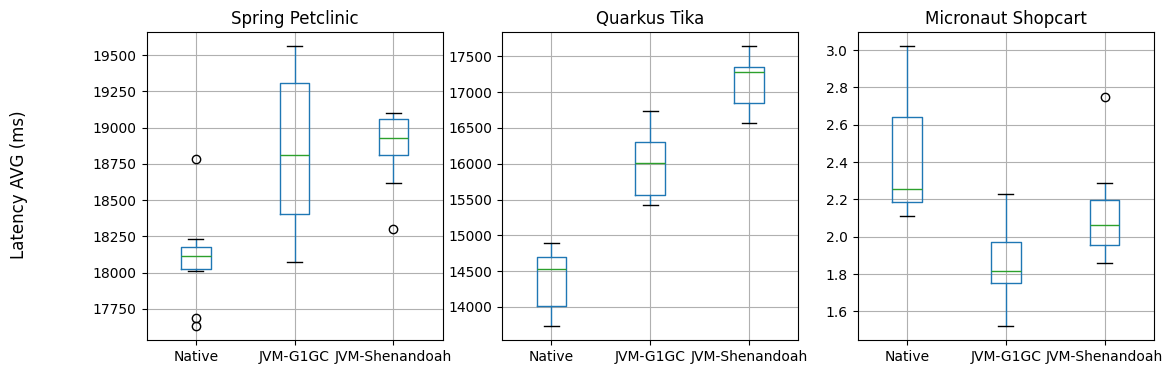

In [32]:
def parse_k(val):
    try:
        if isinstance(val, str) and 'k' in val.lower():
            return float(val.lower().replace('k', '')) * 1000
        return float(val)
    except:
        return val

def to_milliseconds(val, unit):
    try:
        if isinstance(val, str):
            unit = unit.strip().lower()
            if unit == 'ms':
                return float(val)
            elif unit == 's':
                return float(val) * 1000
            elif unit == 'us':
                return float('us') / 1000
        return float(val)
    except:
        return val
    
# returns pd.DataFrame["startup_time", "response_duration"]
def parse_wrk2_output(full_path, prefix) -> pd.DataFrame:
    found_files = list(Path(full_path).glob('*lua.out'))
    if len(found_files) == 0:
        return 
    wrk2_file = found_files[0]

    with open(wrk2_file, 'r') as file:
        raw_text = file.read()
    
    #parse lines
    latency_match = re.search(r'Latency\s+([\d.]+)(ms|us|s)\s+([\d.]+)(ms|us|s)\s+([\d.]+)(ms|us|s)', raw_text)
    reqsec_match_thread = re.search(r"Req/Sec\s+([\d.]+k?)\s+([\d.]+k?)\s+([\d.]+k?)\s+([\d.]+%)", raw_text)
    reqsec_match = re.search(r"Requests/sec:\s+([\d.]+)", raw_text)
    percentil_50 = re.search(r'50.000%\s+([\d.]+)(ms|us|s)', raw_text)
    percentil_75 = re.search(r'75.000%\s+([\d.]+)(ms|us|s)', raw_text)
    percentil_90 = re.search(r'90.000%\s+([\d.]+)(ms|us|s)', raw_text)
    percentil_99 = re.search(r'99.000%\s+([\d.]+)(ms|us|s)', raw_text)
    percentil_999 = re.search(r'99.900%\s+([\d.]+)(ms|us|s)', raw_text)
    result_df = pd.DataFrame(
        [{
            f"{prefix}_latency_match_avg": to_milliseconds(latency_match.group(1), latency_match.group(2)),
            f"{prefix}_latency_match_stdev": to_milliseconds(latency_match.group(3), latency_match.group(4)),
            f"{prefix}_latency_match_max": to_milliseconds(latency_match.group(5), latency_match.group(6)),
            f"{prefix}_reqsec_match_thread_avg": parse_k(reqsec_match_thread).group(1),
            f"{prefix}_reqsec_match_thread_stdev": parse_k(reqsec_match_thread).group(2),
            f"{prefix}_reqsec_match_thread_max": parse_k(reqsec_match_thread).group(3),
            f"{prefix}_reqsec_match": parse_k(reqsec_match).group(1),
            f"{prefix}_percentil_50": to_milliseconds(percentil_50.group(1), percentil_50.group(2)),
            f"{prefix}_percentil_75": to_milliseconds(percentil_75.group(1), percentil_75.group(2)),
            f"{prefix}_percentil_90": to_milliseconds(percentil_90.group(1), percentil_90.group(2)),
            f"{prefix}_percentil_99": to_milliseconds(percentil_99.group(1), percentil_99.group(2)),
            f"{prefix}_percentil_999": to_milliseconds(percentil_999.group(1), percentil_999.group(2)),
        }]
    )

    # values bigger than 1000 will shows with suffix 'k' -> return back to float
    result_df = result_df.map(parse_k)

    return result_df

wrk2_spring_df = pd.concat([
    process_all_files(base_path_petclinic_jvm_g1gc, parse_wrk2_output, "jvm-g1gc"),
    process_all_files(base_path_petclinic_jvm_shenandoah, parse_wrk2_output, "jvm-shenandoah"),
    process_all_files(base_path_petclinic_native, parse_wrk2_output, "native")
], axis=1)

wrk2_quarkus_df = pd.concat([
    process_all_files(base_path_tika_jvm_g1gc, parse_wrk2_output, "jvm-g1gc"),
    process_all_files(base_path_tika_jvm_shenandoah, parse_wrk2_output, "jvm-shenandoah"),
    process_all_files(base_path_tika_native, parse_wrk2_output, "native")
], axis=1)

wrk2_micronaut_df = pd.concat([
    process_all_files(base_path_shopcart_jvm_g1gc, parse_wrk2_output, "jvm-g1gc"),
    process_all_files(base_path_shopcart_jvm_shenandoah, parse_wrk2_output, "jvm-shenandoah"),
    process_all_files(base_path_shopcart_native, parse_wrk2_output, "native")
], axis=1)

fig, axes = plt.subplots(1, 3, figsize=(13, 4))
fig.supylabel("Latency AVG (ms)")
wrk2_spring_df[[
    "native_latency_match_avg", "jvm-g1gc_latency_match_avg", "jvm-shenandoah_latency_match_avg",
]].rename(columns={
        "native_latency_match_avg": "Native",
        "jvm-g1gc_latency_match_avg": "JVM-G1GC",
        "jvm-shenandoah_latency_match_avg": "JVM-Shenandoah"
}).boxplot(ax=axes[0])
axes[0].set_title('Spring Petclinic')

wrk2_quarkus_df[[
    "native_latency_match_avg", "jvm-g1gc_latency_match_avg", "jvm-shenandoah_latency_match_avg",
]].rename(columns={
        "native_latency_match_avg": "Native",
        "jvm-g1gc_latency_match_avg": "JVM-G1GC",
        "jvm-shenandoah_latency_match_avg": "JVM-Shenandoah"
}).boxplot(ax=axes[1])
axes[1].set_title('Quarkus Tika')

wrk2_micronaut_df[[
    "native_latency_match_avg", "jvm-g1gc_latency_match_avg", "jvm-shenandoah_latency_match_avg",
]].rename(columns={
        "native_latency_match_avg": "Native",
        "jvm-g1gc_latency_match_avg": "JVM-G1GC",
        "jvm-shenandoah_latency_match_avg": "JVM-Shenandoah"
}).boxplot(ax=axes[2])
axes[2].set_title('Micronaut Shopcart')

The results show mixed latency behavior across workloads. In Spring Petclinic, native execution achieves ~1,000 ms lower latency and tighter variance than JVM. In Quarkus Tika, however, JVM (both G1GC and Shenandoah) delivers lower latency and fewer outliers, outperforming native. For Micronaut Shopcart, differences are small, with JVM slightly ahead but all modes showing similar variance.

Overall, latency benefits of native images are workload-dependent: while native helps in Petclinic, JVM with JIT and GC optimizations (G1GC/Shenandoah) can outperform in other cases. The presence of outliers in native runs also highlights potential variability in tail latency.

Text(0.5, 1.0, 'Micronaut Shopcart')

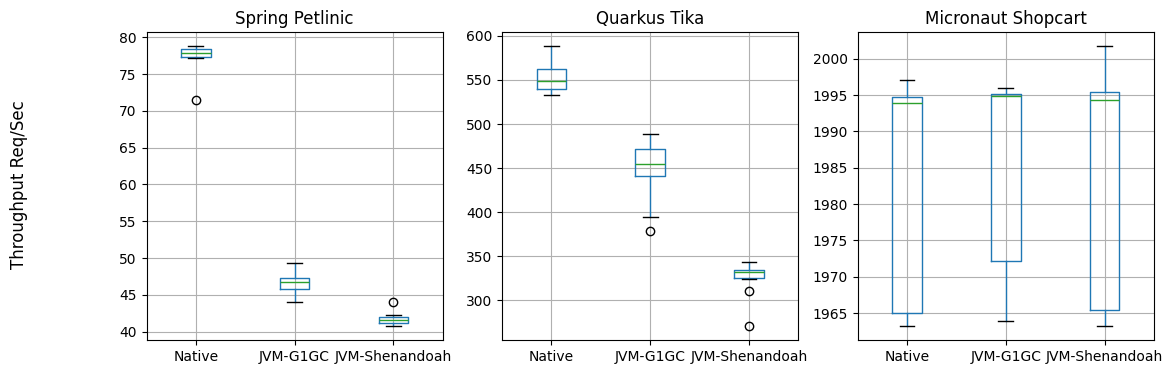

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
fig.supylabel("Throughput Req/Sec")
wrk2_spring_df[[
    "native_reqsec_match", "jvm-g1gc_reqsec_match", "jvm-shenandoah_reqsec_match"
]].rename(columns={
        "native_reqsec_match": "Native",
        "jvm-g1gc_reqsec_match": "JVM-G1GC",
        "jvm-shenandoah_reqsec_match": "JVM-Shenandoah"
}).boxplot(ax=axes[0])
axes[0].set_title('Spring Petlinic')

wrk2_quarkus_df[[
    "native_reqsec_match", "jvm-g1gc_reqsec_match", "jvm-shenandoah_reqsec_match"
]].rename(columns={
        "native_reqsec_match": "Native",
        "jvm-g1gc_reqsec_match": "JVM-G1GC",
        "jvm-shenandoah_reqsec_match": "JVM-Shenandoah"
}).boxplot(ax=axes[1])
axes[1].set_title('Quarkus Tika')

wrk2_micronaut_df[[
    "native_reqsec_match", "jvm-g1gc_reqsec_match", "jvm-shenandoah_reqsec_match"
]].rename(columns={
        "native_reqsec_match": "Native",
        "jvm-g1gc_reqsec_match": "JVM-G1GC",
        "jvm-shenandoah_reqsec_match": "JVM-Shenandoah"
}).boxplot(ax=axes[2])
axes[2].set_title('Micronaut Shopcart')

Throughput results show workload-dependent differences between native and JVM execution.

- In Spring Petclinic, native achieves nearly double the throughput (~78 req/sec vs. ~45 req/sec on JVM), with less variability.
- In Quarkus Tika, native also leads, sustaining ~550 req/sec compared to ~450 (G1GC) and ~330 (Shenandoah).
- In Micronaut Shopcart, all modes reach the system’s ceiling (~1990 req/sec), with negligible differences.

Overall, native images deliver higher throughput in Petclinic and Quarkus, while Micronaut saturates equally across execution modes.

# 99th percentile

While average latency gives a general sense of performance, it often hides performance spikes that affect real users. The 99th percentile latency captures the worst-case (tail) response times experienced by 1 in every 100 requests. This is critical for:

- User experience: In many applications, a small number of slow responses can significantly degrade perceived performance.

- Serverless and autoscaling environments: Tail latencies determine how quickly new instances can respond under load or cold starts.

- SLA compliance: Many service-level agreements are based on tail metrics rather than averages.

JVM-based applications may suffer from outliers due to JIT compilation, GC pauses, or thread contention—making the 99th percentile a key metric for comparison.

**Hypothesis**:

We hypothesize that:

- Native images will exhibit lower and more stable 99th percentile latencies compared to JVM, due to the absence of JIT warm-up and more predictable memory behavior.
- The difference will be most visible in latency-sensitive frameworks (like Micronaut and Quarkus), while more complex frameworks (like Spring Boot) may still suffer from inherent overheads regardless of execution mode.

Text(0.5, 1.0, 'Micronaut Shopcart')

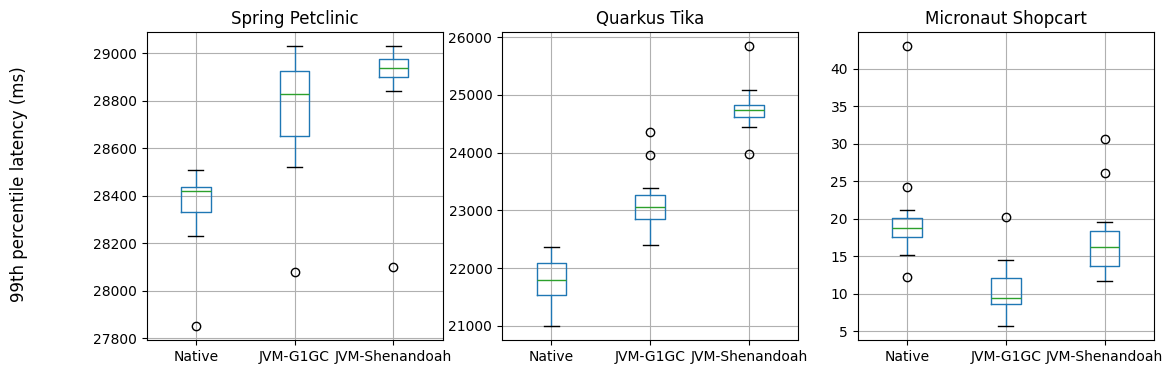

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
fig.supylabel("99th percentile latency (ms)")
wrk2_spring_df[[
    "native_percentil_99", "jvm-g1gc_percentil_99", "jvm-shenandoah_percentil_99",
]].rename(columns={
        "native_percentil_99": "Native",
        "jvm-g1gc_percentil_99": "JVM-G1GC",
        "jvm-shenandoah_percentil_99": "JVM-Shenandoah"
}).boxplot(ax=axes[0])
axes[0].set_title('Spring Petclinic')

wrk2_quarkus_df[[
    "native_percentil_99", "jvm-g1gc_percentil_99", "jvm-shenandoah_percentil_99",
]].rename(columns={
        "native_percentil_99": "Native",
        "jvm-g1gc_percentil_99": "JVM-G1GC",
        "jvm-shenandoah_percentil_99": "JVM-Shenandoah"
}).boxplot(ax=axes[1])
axes[1].set_title('Quarkus Tika')

wrk2_micronaut_df[[
    "native_percentil_99", "jvm-g1gc_percentil_99", "jvm-shenandoah_percentil_99",
]].rename(columns={
        "native_percentil_99": "Native",
        "jvm-g1gc_percentil_99": "JVM-G1GC",
        "jvm-shenandoah_percentil_99": "JVM-Shenandoah"
}).boxplot(ax=axes[2])
axes[2].set_title('Micronaut Shopcart')

The 99th-percentile latency results show mixed outcomes across workloads.

- In Spring Petclinic, native achieves slightly lower tail latency (~28,300 ms vs. ~28,800–29,000 ms on JVM), though differences are modest.
- In Quarkus Tika, native is clearly better, sustaining ~21,500 ms vs. 23,000–25,000 ms on JVM, with fewer extreme outliers.
- In Micronaut Shopcart, all modes maintain very low tail latency (~10–20 ms), though JVM occasionally produces higher spikes.

Overall, native images reduce tail latency in Petclinic and Quarkus, while Micronaut remains efficient across both execution modes.

# RSS

Resident Set Size (RSS) represents the actual portion of memory a process occupies in RAM during execution. It's a key indicator of runtime memory footprint and is especially important in:

- Serverless and containerized environments, where memory resources are limited and billed per usage.

- Autoscaling systems, where smaller footprints allow more instances per host and faster cold starts.

- Microservices architectures, where dozens or hundreds of services may run in parallel, amplifying memory impact.

Comparing RSS between JVM and Native Image is essential because:

- The JVM includes extra overhead from the JIT compiler, metadata, and dynamic class loading.

- Native images eliminate JIT and precompile application logic, which should lead to lower and more stable memory usage.

**Hypothesis**

We hypothesize that:

- Native images will use significantly less RSS memory than their JVM counterparts, due to reduced runtime overhead and statically initialized state.

- The difference will be more pronounced in simpler frameworks like Quarkus and Micronaut, and still noticeable in heavier frameworks like Spring Boot.

RSS is therefore a vital metric for assessing resource efficiency, which is a major factor in deployment scalability and cost in cloud environments.

Text(0.5, 1.0, 'Quarkus RSS native (kB)')

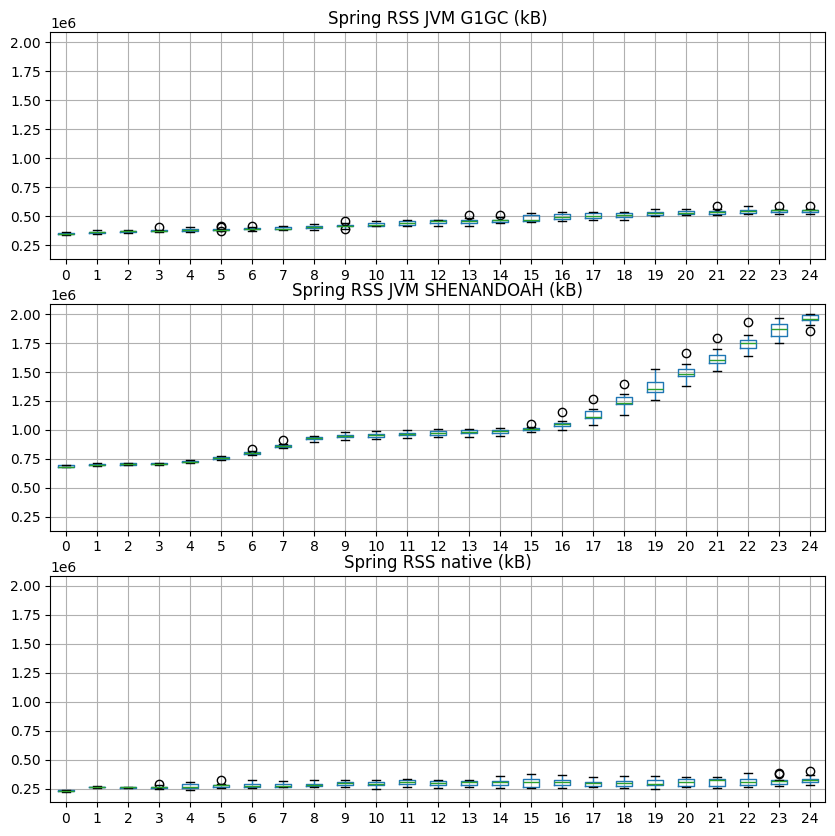

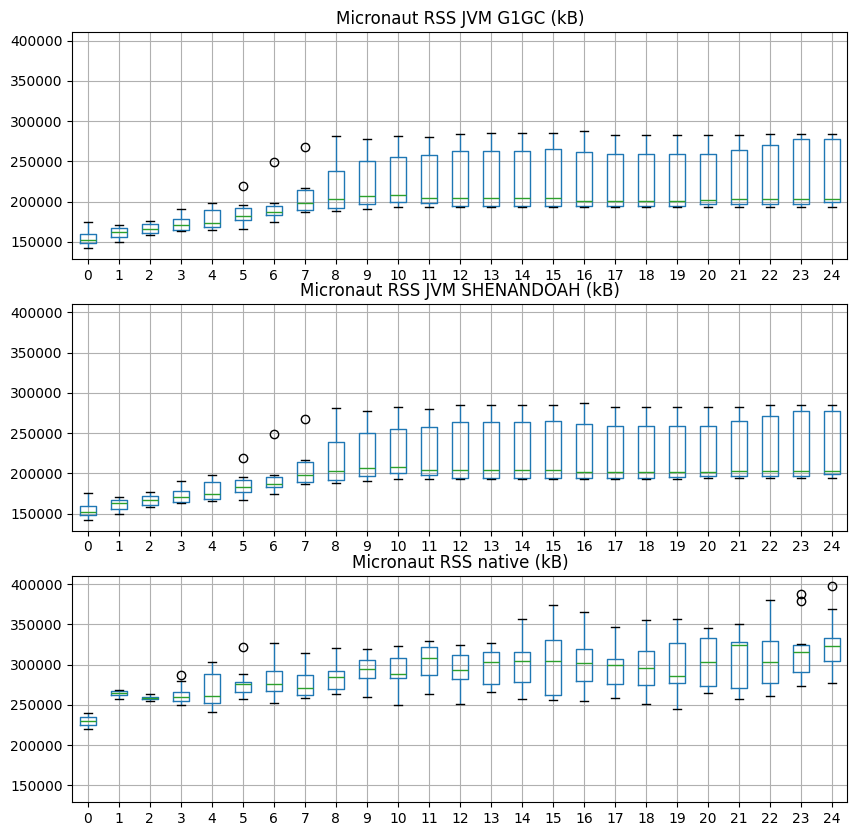

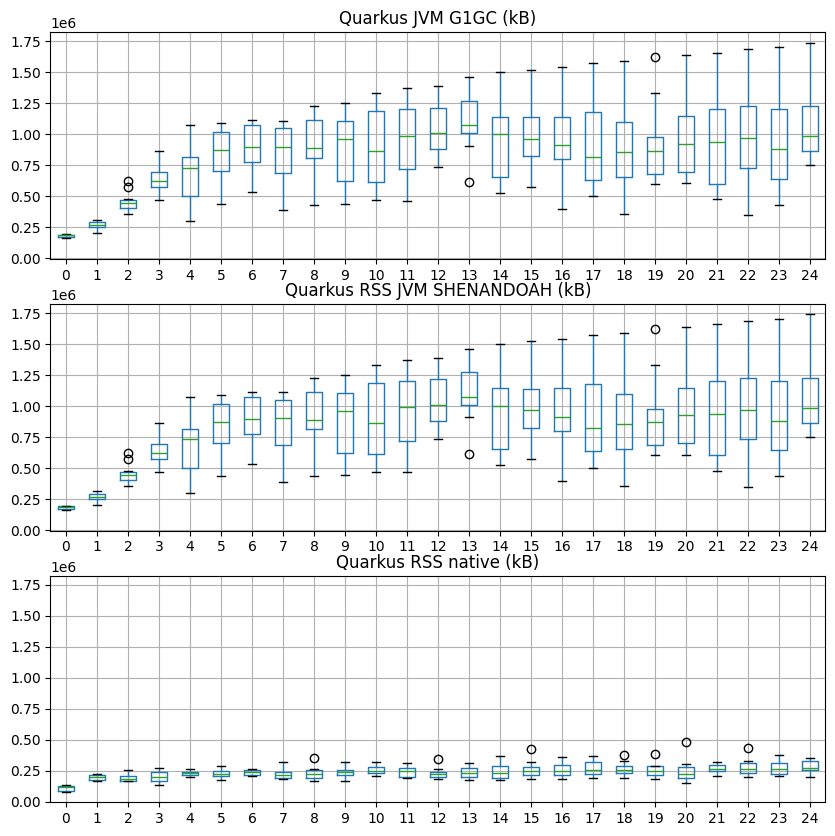

In [44]:
def parse_rss_data(full_path, prefix) -> pd.DataFrame:
    with open(os.path.join(full_path, "rss_info.json"), 'r') as f:
        data = json.load(f)
    res = {}
    # limit values to 25
    for i in range(25):
        res[f"{i}"] = [data[i]['processes'][0]['rss']]
    return pd.DataFrame(res)

rss_petclinic_jvm_g1gc_df = process_all_files(base_path_petclinic_jvm_g1gc, parse_rss_data, "").astype(float)
rss_petclinic_jvm_shenandoah_df = process_all_files(base_path_petclinic_jvm_shenandoah, parse_rss_data, "").astype(float)
rss_petclinic_native_df = process_all_files(base_path_petclinic_native, parse_rss_data, "").astype(float)

rss_shopcart_jvm_g1gc_df = process_all_files(base_path_shopcart_jvm_g1gc, parse_rss_data, "").astype(float)
rss_shopcart_jvm_shenandoah_df = process_all_files(base_path_shopcart_jvm_shenandoah, parse_rss_data, "").astype(float)
rss_shopcart_native_df = process_all_files(base_path_petclinic_native, parse_rss_data, "").astype(float)

rss_quarkus_jvm_g1gc_df = process_all_files(base_path_tika_jvm_g1gc, parse_rss_data, "").astype(float)
rss_quarkus_jvm_shenandoah_df = process_all_files(base_path_tika_jvm_shenandoah, parse_rss_data, "").astype(float)
rss_quarkus_native_df = process_all_files(base_path_tika_native, parse_rss_data, "").astype(float)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,10), sharey=True)

rss_petclinic_jvm_g1gc_df.boxplot(ax=axes[0])
axes[0].set_title('Spring RSS JVM G1GC (kB)')

rss_petclinic_jvm_shenandoah_df.boxplot(ax=axes[1])
axes[1].set_title('Spring RSS JVM SHENANDOAH (kB)')

rss_petclinic_native_df.boxplot(ax=axes[2])
axes[2].set_title('Spring RSS native (kB)')

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,10), sharey=True)

rss_shopcart_jvm_g1gc_df.boxplot(ax=axes[0])
axes[0].set_title('Micronaut RSS JVM G1GC (kB)')

rss_shopcart_jvm_g1gc_df.boxplot(ax=axes[1])
axes[1].set_title('Micronaut RSS JVM SHENANDOAH (kB)')

rss_shopcart_native_df.boxplot(ax=axes[2])
axes[2].set_title('Micronaut RSS native (kB)')

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,10), sharey=True)

rss_quarkus_jvm_g1gc_df.boxplot(ax=axes[0])
axes[0].set_title('Quarkus JVM G1GC (kB)')

rss_quarkus_jvm_g1gc_df.boxplot(ax=axes[1])
axes[1].set_title('Quarkus RSS JVM SHENANDOAH (kB)')

rss_quarkus_native_df.boxplot(ax=axes[2])
axes[2].set_title('Quarkus RSS native (kB)')


The RSS measurements confirm a consistent memory efficiency advantage for native images across all frameworks.

- In Spring Petclinic, JVM memory steadily increases, with Shenandoah climbing close to 2 GB and G1GC reaching ~0.5 GB, while the native footprint stays stable around 250–300 MB.
- In Micronaut Shopcart, all modes consume less memory overall, but JVM processes grow toward ~300 MB, whereas the native footprint remains slightly lower and more stable (~250 MB).
- In Quarkus Tika, the gap is most striking: JVM memory grows beyond 1.5 GB with high variance, while native execution remains consistently below 300 MB throughout.

These results highlight that native images avoid the overhead of JIT compilation, class metadata, and GC tuning structures, leading to a smaller and more predictable memory footprint. The effect is especially strong in larger workloads like Spring and Quarkus.

# CPU Usage

CPU utilization reflects how much processing power an application consumes under load. It is a key metric for understanding runtime efficiency and is particularly important when comparing JVM and native image execution because:

- JVM applications may use more CPU due to JIT compilation, background threads (e.g., for GC and classloading), and warm-up phases.

- Native images, compiled ahead of time, eliminate JIT and often use simpler memory and thread management, potentially leading to lower CPU consumption.

By measuring CPU usage, we can determine:

- Which runtime is more efficient under sustained load

- How much overhead is introduced by the JVM's dynamic optimizations

- Whether native images deliver comparable performance with fewer CPU resources

This is especially valuable in cloud environments, where CPU usage affects autoscaling, instance density, and operating costs.

**Hypothesis**

We hypothesize that:

- Native images will consume less CPU than JVM applications under equivalent load, especially during startup and steady-state operation.

- The difference will be more visible in complex applications like Spring Boot, where JVM overhead is higher.

CPU metrics help assess not just performance, but cost-efficiency and scalability—key concerns for modern microservice and serverless deployments.

Text(0.5, 1.0, 'Micronaut Shopcart Native')

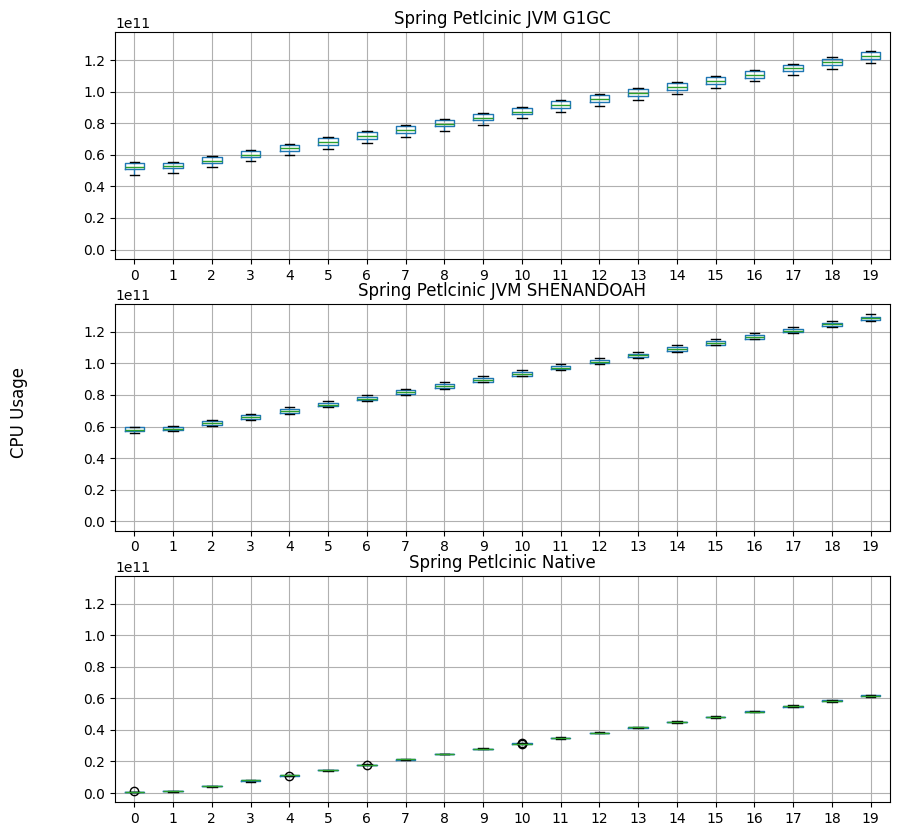

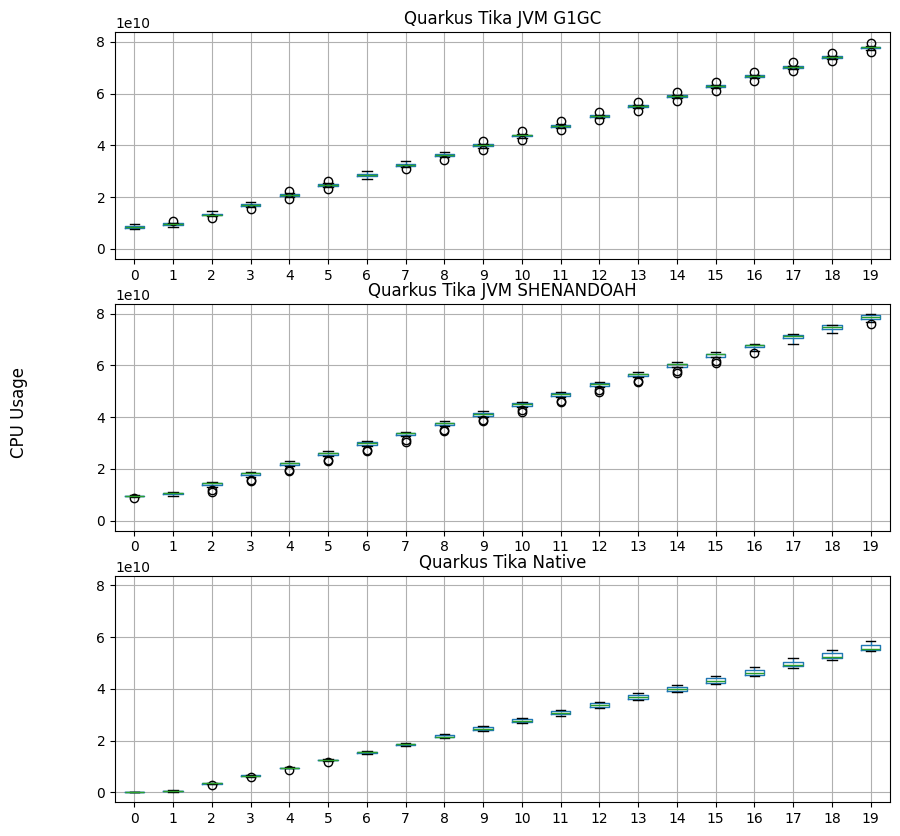

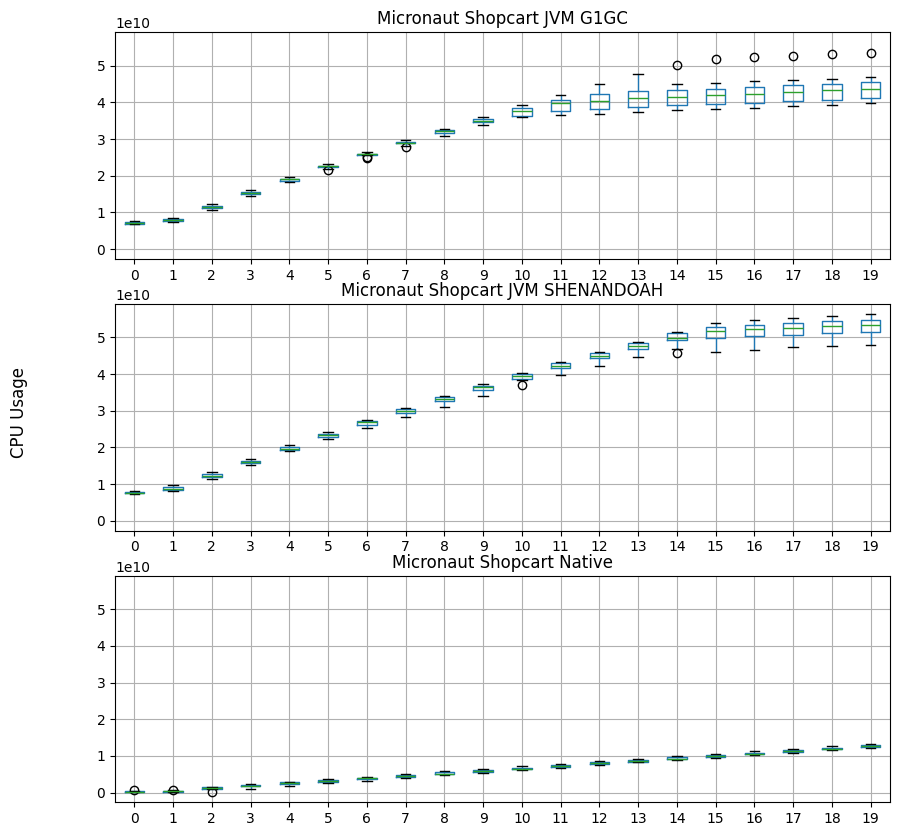

In [50]:
def parse_container_stats(full_path, prefix) -> pd.DataFrame:
    full_path = os.path.join(full_path, "container-stats.csv")
    res = {}
    conatainer_df = pd.read_csv(full_path)
    for i in range(20):
        res[f"{i}"] = [conatainer_df.at[conatainer_df.index[i], 'cpu_usage']]
    return pd.DataFrame(res)

spring_jvm_g1gc_df = process_all_files(base_path_petclinic_jvm_g1gc, parse_container_stats, "")
spring_jvm_shenandoah_df = process_all_files(base_path_petclinic_jvm_shenandoah, parse_container_stats, "")
spring_native_df = process_all_files(base_path_petclinic_native, parse_container_stats, "")

quarkus_jvm_g1gc_df = process_all_files(base_path_tika_jvm_g1gc, parse_container_stats, "")
quarkus_jvm_shenandoah_df = process_all_files(base_path_tika_jvm_shenandoah, parse_container_stats, "")
quarkus_native_df = process_all_files(base_path_tika_native, parse_container_stats, "")

shopcart_jvm_g1gc_df = process_all_files(base_path_shopcart_jvm_g1gc, parse_container_stats, "")
shopcart_jvm_shenandoah_df = process_all_files(base_path_shopcart_jvm_shenandoah, parse_container_stats, "")
shopcart_native_df = process_all_files(base_path_shopcart_native, parse_container_stats, "")

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,10), sharey=True)
fig.supylabel("CPU Usage")

spring_jvm_g1gc_df.boxplot(ax=axes[0])
axes[0].set_title('Spring Petlcinic JVM G1GC')
spring_jvm_shenandoah_df.boxplot(ax=axes[1])
axes[1].set_title('Spring Petlcinic JVM SHENANDOAH')
spring_native_df.boxplot(ax=axes[2])
axes[2].set_title('Spring Petlcinic Native')

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,10), sharey=True)
fig.supylabel("CPU Usage")

quarkus_jvm_g1gc_df.boxplot(ax=axes[0])
axes[0].set_title('Quarkus Tika JVM G1GC')
quarkus_jvm_shenandoah_df.boxplot(ax=axes[1])
axes[1].set_title('Quarkus Tika JVM SHENANDOAH')
quarkus_native_df.boxplot(ax=axes[2])
axes[2].set_title('Quarkus Tika Native')

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,10), sharey=True)
fig.supylabel("CPU Usage")

shopcart_jvm_g1gc_df.boxplot(ax=axes[0])
axes[0].set_title('Micronaut Shopcart JVM G1GC')
shopcart_jvm_shenandoah_df.boxplot(ax=axes[1])
axes[1].set_title('Micronaut Shopcart JVM SHENANDOAH')
shopcart_native_df.boxplot(ax=axes[2])
axes[2].set_title('Micronaut Shopcart Native')

The CPU usage measurements, expressed as cumulative CPU cycles, highlight clear differences in computational overhead between native and JVM execution.

- In Spring Petclinic and Quarkus Tika, both execution modes scale linearly with workload, but the JVM consistently consumes significantly more CPU across all intervals. This reflects JVM runtime overhead from garbage collection, JIT compilation, and thread scheduling, whereas native images avoid these costs.
- In Micronaut Shopcart, CPU demand is substantially lower overall. The gap between JVM and native is also much smaller, suggesting that for lightweight frameworks, native execution offers only modest CPU savings. Micronaut’s efficient runtime minimizes differences between execution models.

Overall, native images demonstrate more efficient CPU utilization, especially in larger workloads, while lightweight applications like Micronaut narrow the gap.

# Conclusion

The analysis shows that GraalVM native images consistently outperform JVM execution in startup time, memory usage, and CPU efficiency across all frameworks. These strengths make native execution especially well-suited for serverless and resource-constrained environments.

In terms of latency, native images often achieve lower or comparable averages and tail latencies, though results vary by workload. For throughput, however, the JVM sometimes performs better (e.g., Quarkus Tika), benefiting from JIT optimizations and adaptive GC strategies. Between the two JVM garbage collectors, G1GC and Shenandoah show broadly similar performance, but Shenandoah occasionally incurs higher memory usage under load.

Overall, native images provide faster startup and lower resource consumption, while the JVM—depending on GC choice and workload—can still excel in sustained high-throughput scenarios.